![](https://i.pinimg.com/564x/f9/ae/ef/f9aeef0f646f4711bfaf5d837f8766e2.jpg)

# Extended Kalman Filter

Kevin J. Walchko, Phd

21 June 2020

---

## Continous System, Discrete Measurement EKF

Given a process model of the following form:

$$
\dot x(t) = f(x(t), u(t)) + w(t) \quad w(t) \sim \mathcal{N}(0,Q(t))\\
z_k = h(x_k) + v_k \quad v_k \sim \mathcal{N}(0,R_k)
$$


1. Initialize
$$
\hat x_0^- = E[x_k] \\
P^-_0 = E[(x_0-\hat x_0)(x_0-\hat x_0)^T]
$$
1. Calculate Gain Matrix
$$
K_k=P_k^- H_k^T [H_k P^-_k H^T_k + R_k]^{-1} \\
$$
1. Update State and Error Covariance
$$
\hat x_{k} = \hat x_k^- + K_k[z_k - h(\hat x_k^-,u_k)] \\
P_k = [I-K_kH_k]P^-_k
$$
1. Predict
$$
\text{Solve} \begin{cases}
\dot{\hat x}(t) = f(\hat x(t), u(t))\\
\dot P(t)=F(t)P(t)+P(t)F(t)^T+Q(t)
\end{cases}\\
\Rightarrow \begin{cases}
\hat x_{k} = \hat x(t_k) \\
P_{k} = P(t_k)
\end{cases}
$$
where the linearized approximations are:
$$
F_k=\frac{\partial f_k}{\partial x} \Bigr|_{\hat x^-_k, u_k} \\
H_k=\frac{\partial h_k}{\partial x} \Bigr|_{\hat x^-_k}
$$



## References

- Wikipedia: [Extended Kalman Filter, discrete time](https://en.wikipedia.org/wiki/Extended_Kalman_filter#Discrete-time_measurements)
- Gelb, Arthur, "[Applied Optimal Estimation](http://users.isr.ist.utl.pt/~pjcro/temp/Applied%20Optimal%20Estimation%20-%20Gelb.pdf)," The M.I.T Press, 2001, Table 6.1-1, pg 188

## EOM

The EKF state vector ($x_k$) is:

$$
x_k = \begin{bmatrix} p^{NED}_k & v^{NED}_k & q_k & gyroBias_k & accelBias_k & scaleFactor \end{bmatrix}^T \\
q_k \Rightarrow R^{NED}_b
$$

where $p$ is position, $v$ is velocity, $q$ is the quaternion of the body relative to the inertial frame. The eqations of motion that drive this state are:

$$
p^{NED}_k = p^{NED}_{k-1} + v^{NED}_k \Delta t \\
v^{NED}_k = v^{NED}_{k-1} + R^{NED}_b (a_k-accelBias_k) + g^{NED} \\
\dot q_{k-1} = \frac{1}{2} q_{k-1} \otimes (w_k - gyroBias_k) \\
q_k = q_{k-1} + \dot q_{k-1}\Delta t \\
$$

In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import numpy as np
from numpy.linalg import norm
from numpy.testing import assert_allclose
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
from math import pi, sin, cos, atan2, asin, acos

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)

from the_collector import BagIt, Pickle

from squaternion import Quaternion

In [14]:
deg2rad = pi/180
rad2deg = 180/pi

In [15]:
def bag_info(bag):
    print('Bag keys:')
    print('-'*50)
    for k in bag.keys():
        print(f'  {k:>10}: {len(bag[k]):<7}')
        
bag = BagIt(Pickle)
data = bag.read("sim.pickle.bag")
bag_info(data)

>> Reading[pickle]: sim.pickle.bag
Bag keys:
--------------------------------------------------
       truth: 100    
        meas: 100    


In [16]:
truth = np.array(data["truth"])
meas = np.array(data["meas"])

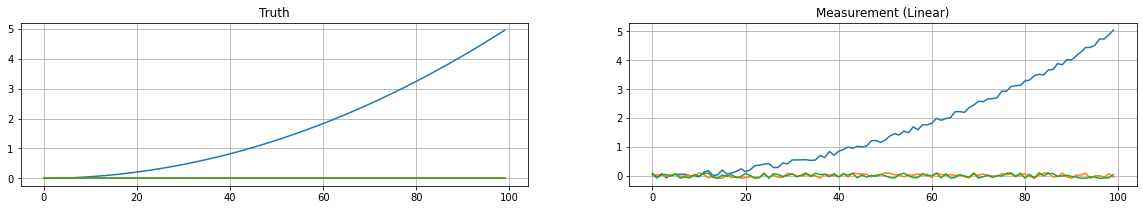

In [17]:
plt.subplot(1,2,1); plt.plot(truth[:,:3]); plt.grid(True);plt.title("Truth");
plt.subplot(1,2,2); plt.plot(meas[:,:3]); plt.grid(True);plt.title("Measurement (Linear)");

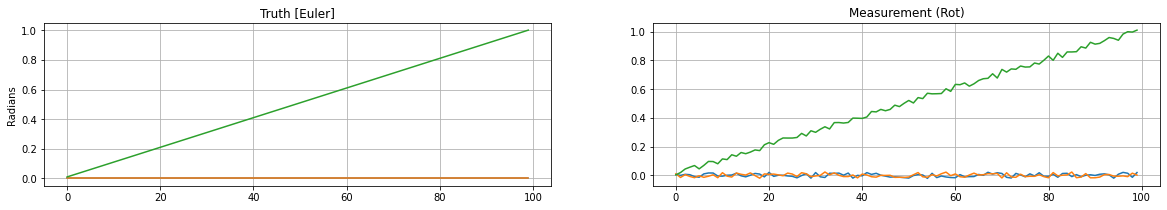

In [18]:
# print(truth)
teuler = []
for vv in truth:
    v = vv[6:]
    q = Quaternion(*v)
    teuler.append(q.to_euler())

meuler = []
for vv in meas:
    v = vv[6:]
    q = Quaternion(*v)
    meuler.append(q.to_euler())
    
# plt.subplot(1,2,1); plt.plot(truth[:,6:]); plt.grid(True);plt.title("Truth");
plt.subplot(1,2,1); plt.plot(teuler); plt.grid(True);plt.title("Truth [Euler]");
plt.ylabel("Radians");
plt.subplot(1,2,2); plt.plot(meuler); plt.grid(True);plt.title("Measurement (Rot)");

In [19]:
import attr

@attr.s(slots=True)
class Jacobian:
    f=attr.ib() # function
    
    # cache some variables to save processing time
    n=attr.ib(init=False, default=None)
    jac=attr.ib(init=False, default=None)
    
    
@attr.s(slots=True)
class JacobianForward(Jacobian):
    def __call__(self, x, dx=1e-8):
        if self.n is None:
            self.n = len(x)
            self.jac = np.zeros((self.n, self.n))
        func = self.f(x)
        
        for j in range(self.n):
            Dxj = (abs(x[j])*dx if x[j] != 0 else dx)
            d = np.zeros(self.n)
            d[j] = Dxj
            self.jac[:, j] = (self.f(x+d) - func)/Dxj
        return self.jac
    
    
@attr.s(slots=True)
class JacobianCenter(Jacobian):
    def __call__(self, x, dx=1e-8):
        if self.n is None:
            self.n = len(x)
            self.jac = np.zeros((self.n, self.n))
        for j in range(self.n):
            Dxj = (abs(x[j])*dx if x[j] != 0 else dx)
            d = np.zeros(self.n)
            d[j] = Dxj
            self.jac[:, j] = (self.f(x+d) - self.f(x-d))/(2*Dxj)
        return self.jac
    

In [20]:
class EKF:
    def __init__(self, dt):
        """
        v=[
            p[0:2]
            v[3:5]
            q[6:9]
        ] - 10
        """
        self.J = JacobianCenter(self.func)
        self.dt = dt
        
    def func(self, x, u=None):
        if u is None:
            u = np.zeros(6)
            
        p = x[:3] + x[3:6]*self.dt
        
        q = Quaternion(*x[6:])
        rot = np.array(q.to_rot())
        g = np.array([0,0,-9.8])
        a = np.array([0,0,9.8])
        # aa = rot.dot(a)
        v = x[3:6]+g*self.dt+rot.dot(a)*self.dt
        
        w = Quaternion(0,u[3],u[4],u[5])
        q = q + 0.5*w*q*self.dt
        
        xx = np.array([0,0,0, 0,0,0, q.w,q.x,q.y,q.z])
        xx[:3] = p
        xx[3:6] = v
        
        return xx
        
    def reset(self):
        n = 10
        self.R = np.eye(n)
        self.Q = np.eye(n)
        self.P = np.eye(n)
        
        p = np.array([0,0,0])
        v = np.array([0,0,0])
        q = np.array([1,0,0,0])
        
        self.x = np.hstack((p,v,q))
        
    def predict(self, u):
        self.x = self.func(self.x,u)
        self.F = self.J(self.x)
        
        dP = self.F.dot(self.P)+self.P.dot(self.F.T)+self.Q
#         dP = self.F.dot(self.P.dot(self.F.T))+self.Q
        I = np.eye(dP.shape[0])
        self.P = I+dP*self.dt
        
#         self.P = self.F.dot(self.P.dot(self.F.T))+self.Q
        
    def update(self, z):
        # H = np.eye(len(self.x))
        H = np.diag([0,0,0, 1,1,1, 1,1,1,1])
        I = np.eye(len(self.x))

        # kalman gain
        S = H.dot(self.P.dot(H.T)) + self.R
        K = self.P.dot(H.T.dot(np.linalg.inv(S)))

        # update
        zk = z - H.dot(self.x)
        x = self.x + K.dot(zk)
        P = (I - K.dot(H)).dot(self.P)

        q = Quaternion(*x[6:])
        if abs(1 - q.magnitude) > 1e-6:
            q.normalize
            x[6] = q.w
            x[7] = q.x
            x[8] = q.y
            x[9] = q.z

        self.x = x
        self.P = P

        return x

In [21]:
ekf = EKF(0.1)
ekf.reset()

num = len(data["meas"])

noise = np.random.uniform(-0.001,0.001,(num,10))

p = []
save = []
ts = []
perr = []
rerr = []
cov = []
t = 0
for i in range(num):
    u = np.array([0,0,0,  0,0,0])
    ekf.predict(u)
    
    meas = data["meas"][i]
    y = ekf.update(meas[i,:])
    p.append(np.trace(ekf.P))
    
    cov.append(np.trace(ekf.P))
    save.append(y)
    perr.append(norm(truth[i,:3] - y[:3]))
    rerr.append(norm(truth[i,-4:] - y[-4:]))
    ts.append(t)
    t += ekf.dt
    
save = np.array(save)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

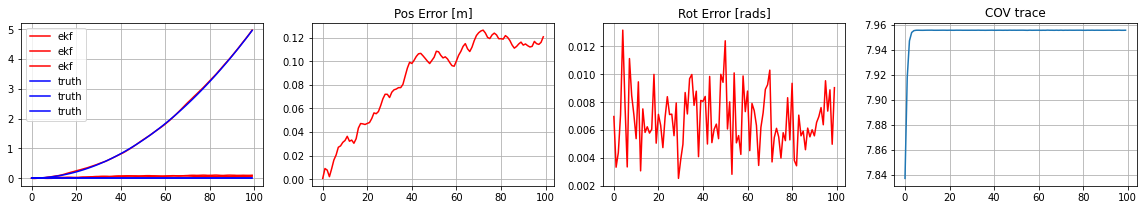

In [11]:
plt.subplot(1,4,1)
plt.plot(save[:,:3],'-r',label='ekf')
plt.plot(truth[:,:3],'-b',label='truth')
# plt.axis('equal')
plt.grid(True)
plt.legend();

plt.subplot(1,4,2)
plt.plot(perr,'-r',label='error')
plt.grid(True);
plt.title("Pos Error [m]")

plt.subplot(1,4,3)
plt.plot(rerr,'-r',label='error')
plt.grid(True);
plt.title("Rot Error [rads]")

plt.subplot(1,4,4)
plt.plot(cov)
plt.grid(True)
plt.title("COV trace");

In [147]:
rad2deg*0.15

8.594366926962348